In [72]:
!pip install kagglehub --upgrade

In [73]:
import kagglehub

In [74]:
import kagglehub

# download the dataset from kaggle

kagglehub.dataset_download("undefinenull/million-song-dataset-spotify-lastfm")

'/root/.cache/kagglehub/datasets/undefinenull/million-song-dataset-spotify-lastfm/versions/1'

In [75]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
data_path = Path("/root/.cache/kagglehub/datasets/undefinenull/million-song-dataset-spotify-lastfm/versions/1")

songs_data_path = data_path / "Music Info.csv"
users_data_path = data_path / "User Listening History.csv"

In [77]:
# songs_data

songs_df = pd.read_csv(songs_data_path, usecols=['track_id', 'name', 'artist', 'spotify_preview_url'])

songs_df.head()

,track_id,name,artist,spotify_preview_url
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...


In [78]:
!pip install dask[dataframe]

In [79]:
import dask.dataframe as dd

# load the dataset
df = dd.read_csv(users_data_path)

# check the first few rows to verify the data
df.head()

,track_id,user_id,playcount
0,TRIRLYL128F42539D1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
1,TRFUPBA128F934F7E1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
2,TRLQPQJ128F42AA94F,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
3,TRTUCUY128F92E1D24,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
4,TRHDDQG12903CB53EE,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1


In [80]:
df.npartitions

9

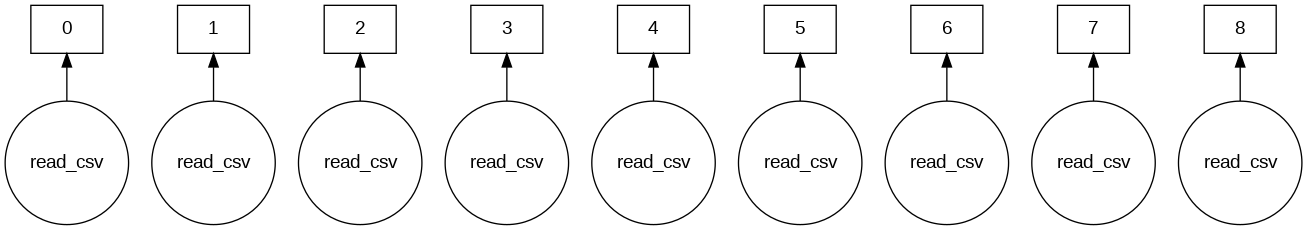

In [81]:
df.visualize(tasks=True)

In [82]:
# number of unique racks in the data

unique_tracks = df.loc[:, 'track_id'].nunique()
unique_tracks

<dask_expr.expr.Scalar: expr=(DropDuplicates(frame=ReadCSV(50aee3f)['track_id'], split_every=False)).count(), dtype=int64>

In [83]:
unique_tracks = unique_tracks.compute()
unique_tracks

30459

In [84]:
# number of unique users in the data

unique_users = df.loc[:,'user_id'].nunique()

unique_users = unique_users.compute()

unique_users

962037

In [85]:
# list of unique track_ids

unique_track_ids = df.loc[:, 'track_id'].unique().compute()

unique_track_ids = unique_track_ids.tolist()

In [86]:
len(unique_track_ids)

30459

In [87]:
# filtered songs

filtered_songs = songs_df[songs_df['track_id'].isin(unique_track_ids)]

filtered_songs.reset_index(drop=True, inplace=True)

filtered_songs.head()

,track_id,name,artist,spotify_preview_url
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...
2,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...
3,TRXOGZT128F424AD74,Karma Police,Radiohead,https://p.scdn.co/mp3-preview/5a09f5390e2862af...
4,TRUJIIV12903CA8848,Clocks,Coldplay,https://p.scdn.co/mp3-preview/24c7fe858b234e3c...


In [88]:
filtered_songs[filtered_songs['name'] == 'Crazy in Love']

,track_id,name,artist,spotify_preview_url
3337,TROINZB128F932F740,Crazy in Love,Beyoncé,https://p.scdn.co/mp3-preview/807828ea7070bda7...


In [108]:
import dask.dataframe as dd
import numpy as np
from scipy.sparse import csr_matrix

# Step 1: Load data with Dask
# Assume the dataset is in a CSV file

df = dd.read_csv(users_data_path)

# step 2: Ensure playcount is numeric
df['playcount'] = df['playcount'].astype(np.float64)
df = df.categorize(columns=['user_id', 'track_id'])  # converting user_id and track_id to categorical columns

"""Dask handles categorical data more efficiently in a distributed environment.
  Since Dask operates on chunks of data,
converting user_id and track_id to categorical ensures consistency across partitions."""


# step 3: convert user_id and track_id to numeric indices
"""cat.codes assigns a unique integer index to each user_id and track_id,
 which is necessary for creating a sparse matrix"""
user_mapping = df['user_id'].cat.codes
track_mapping = df['track_id'].cat.codes

df = df.assign(
    user_idx=user_mapping,
    track_idx=track_mapping
    )

Converting user_id and track_id into **categorical columns** in Dask (df.categorize(columns=['user_id', 'track_id'])) is useful for **efficient memory usage and numerical encoding.**

**Why Convert user_id and track_id to Categorical?**

**1. Reduces Memory Usage:**

If user_id and track_id are stored as regular strings or integers, they take up more memory.
Categorical data stores unique values once and replaces them with integer codes internally, reducing memory usage.

**2. Speeds Up Computations:**

Comparisons, filtering, and grouping operations are faster on categorical data than on raw strings or integers.
When performing operations like groupby on user_id, it's much faster on categorical data.

**3. Enables Efficient Encoding for Sparse Matrices:**

To create a user-item matrix (which is usually sparse in recommender systems), we need numeric indices.
Categories allow mapping unique user_id and track_id to numeric indices (0, 1, 2, …) using .cat.codes.


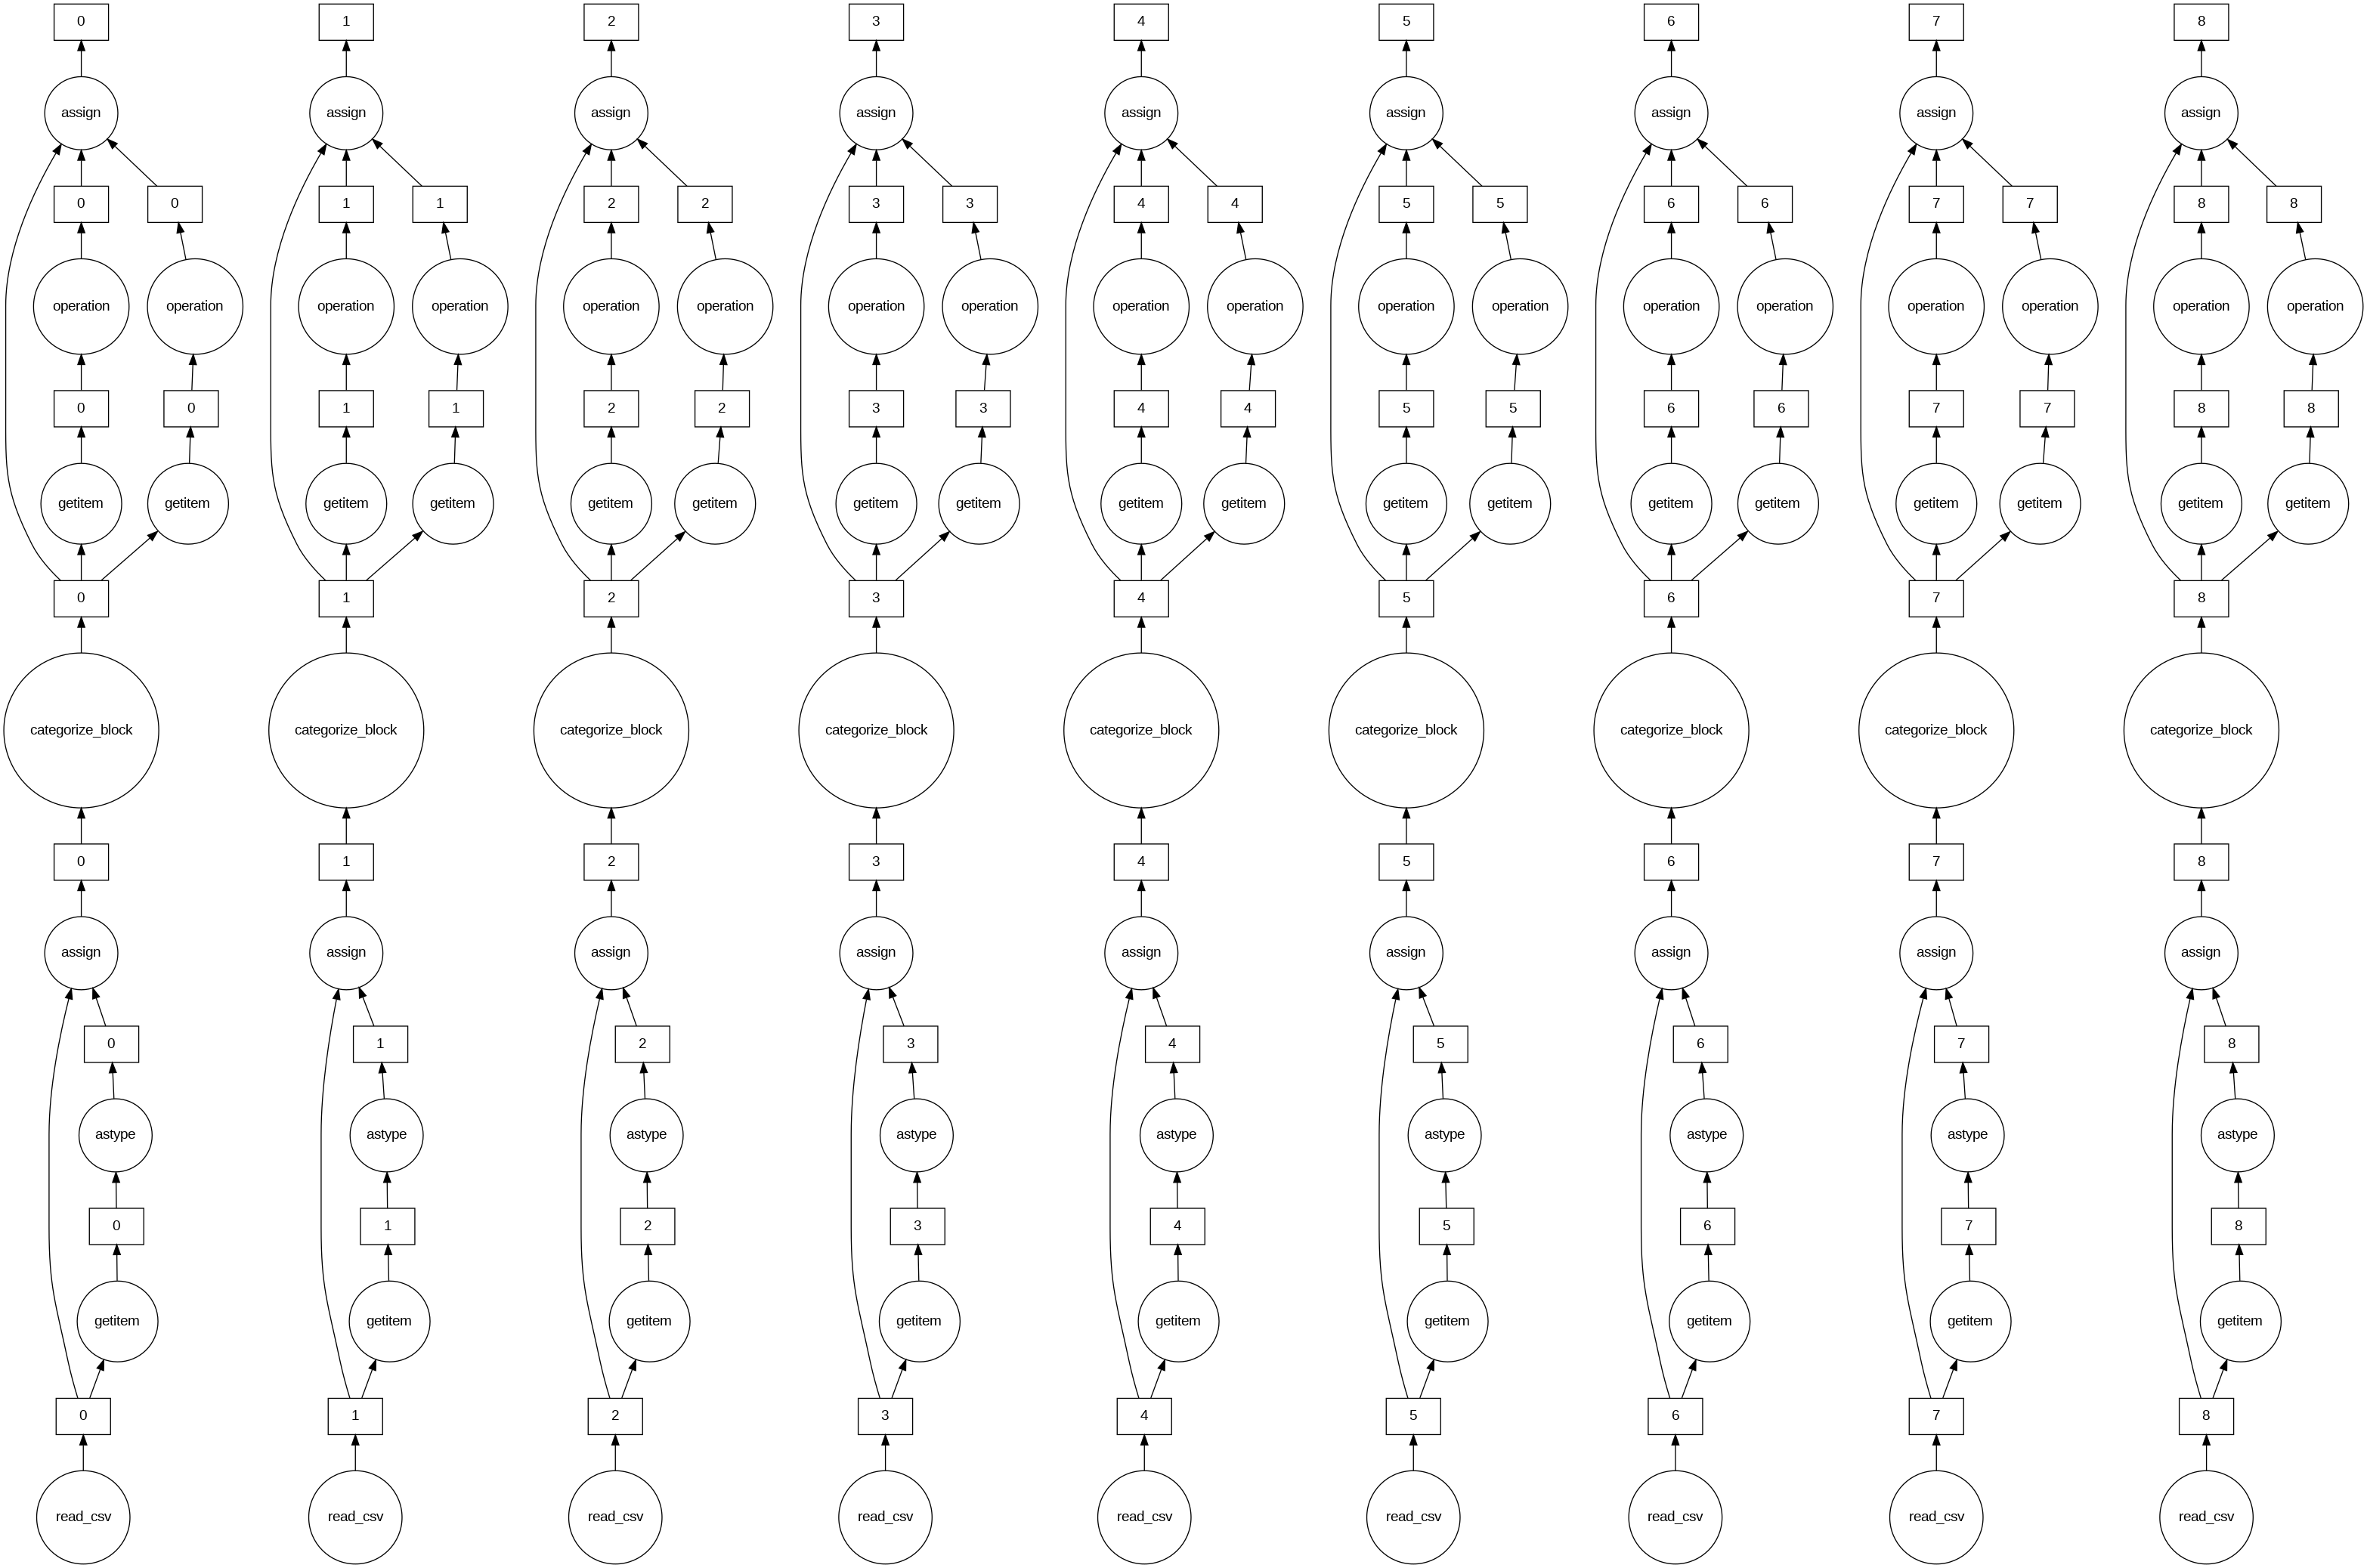

In [90]:
df.visualize(tasks=True)

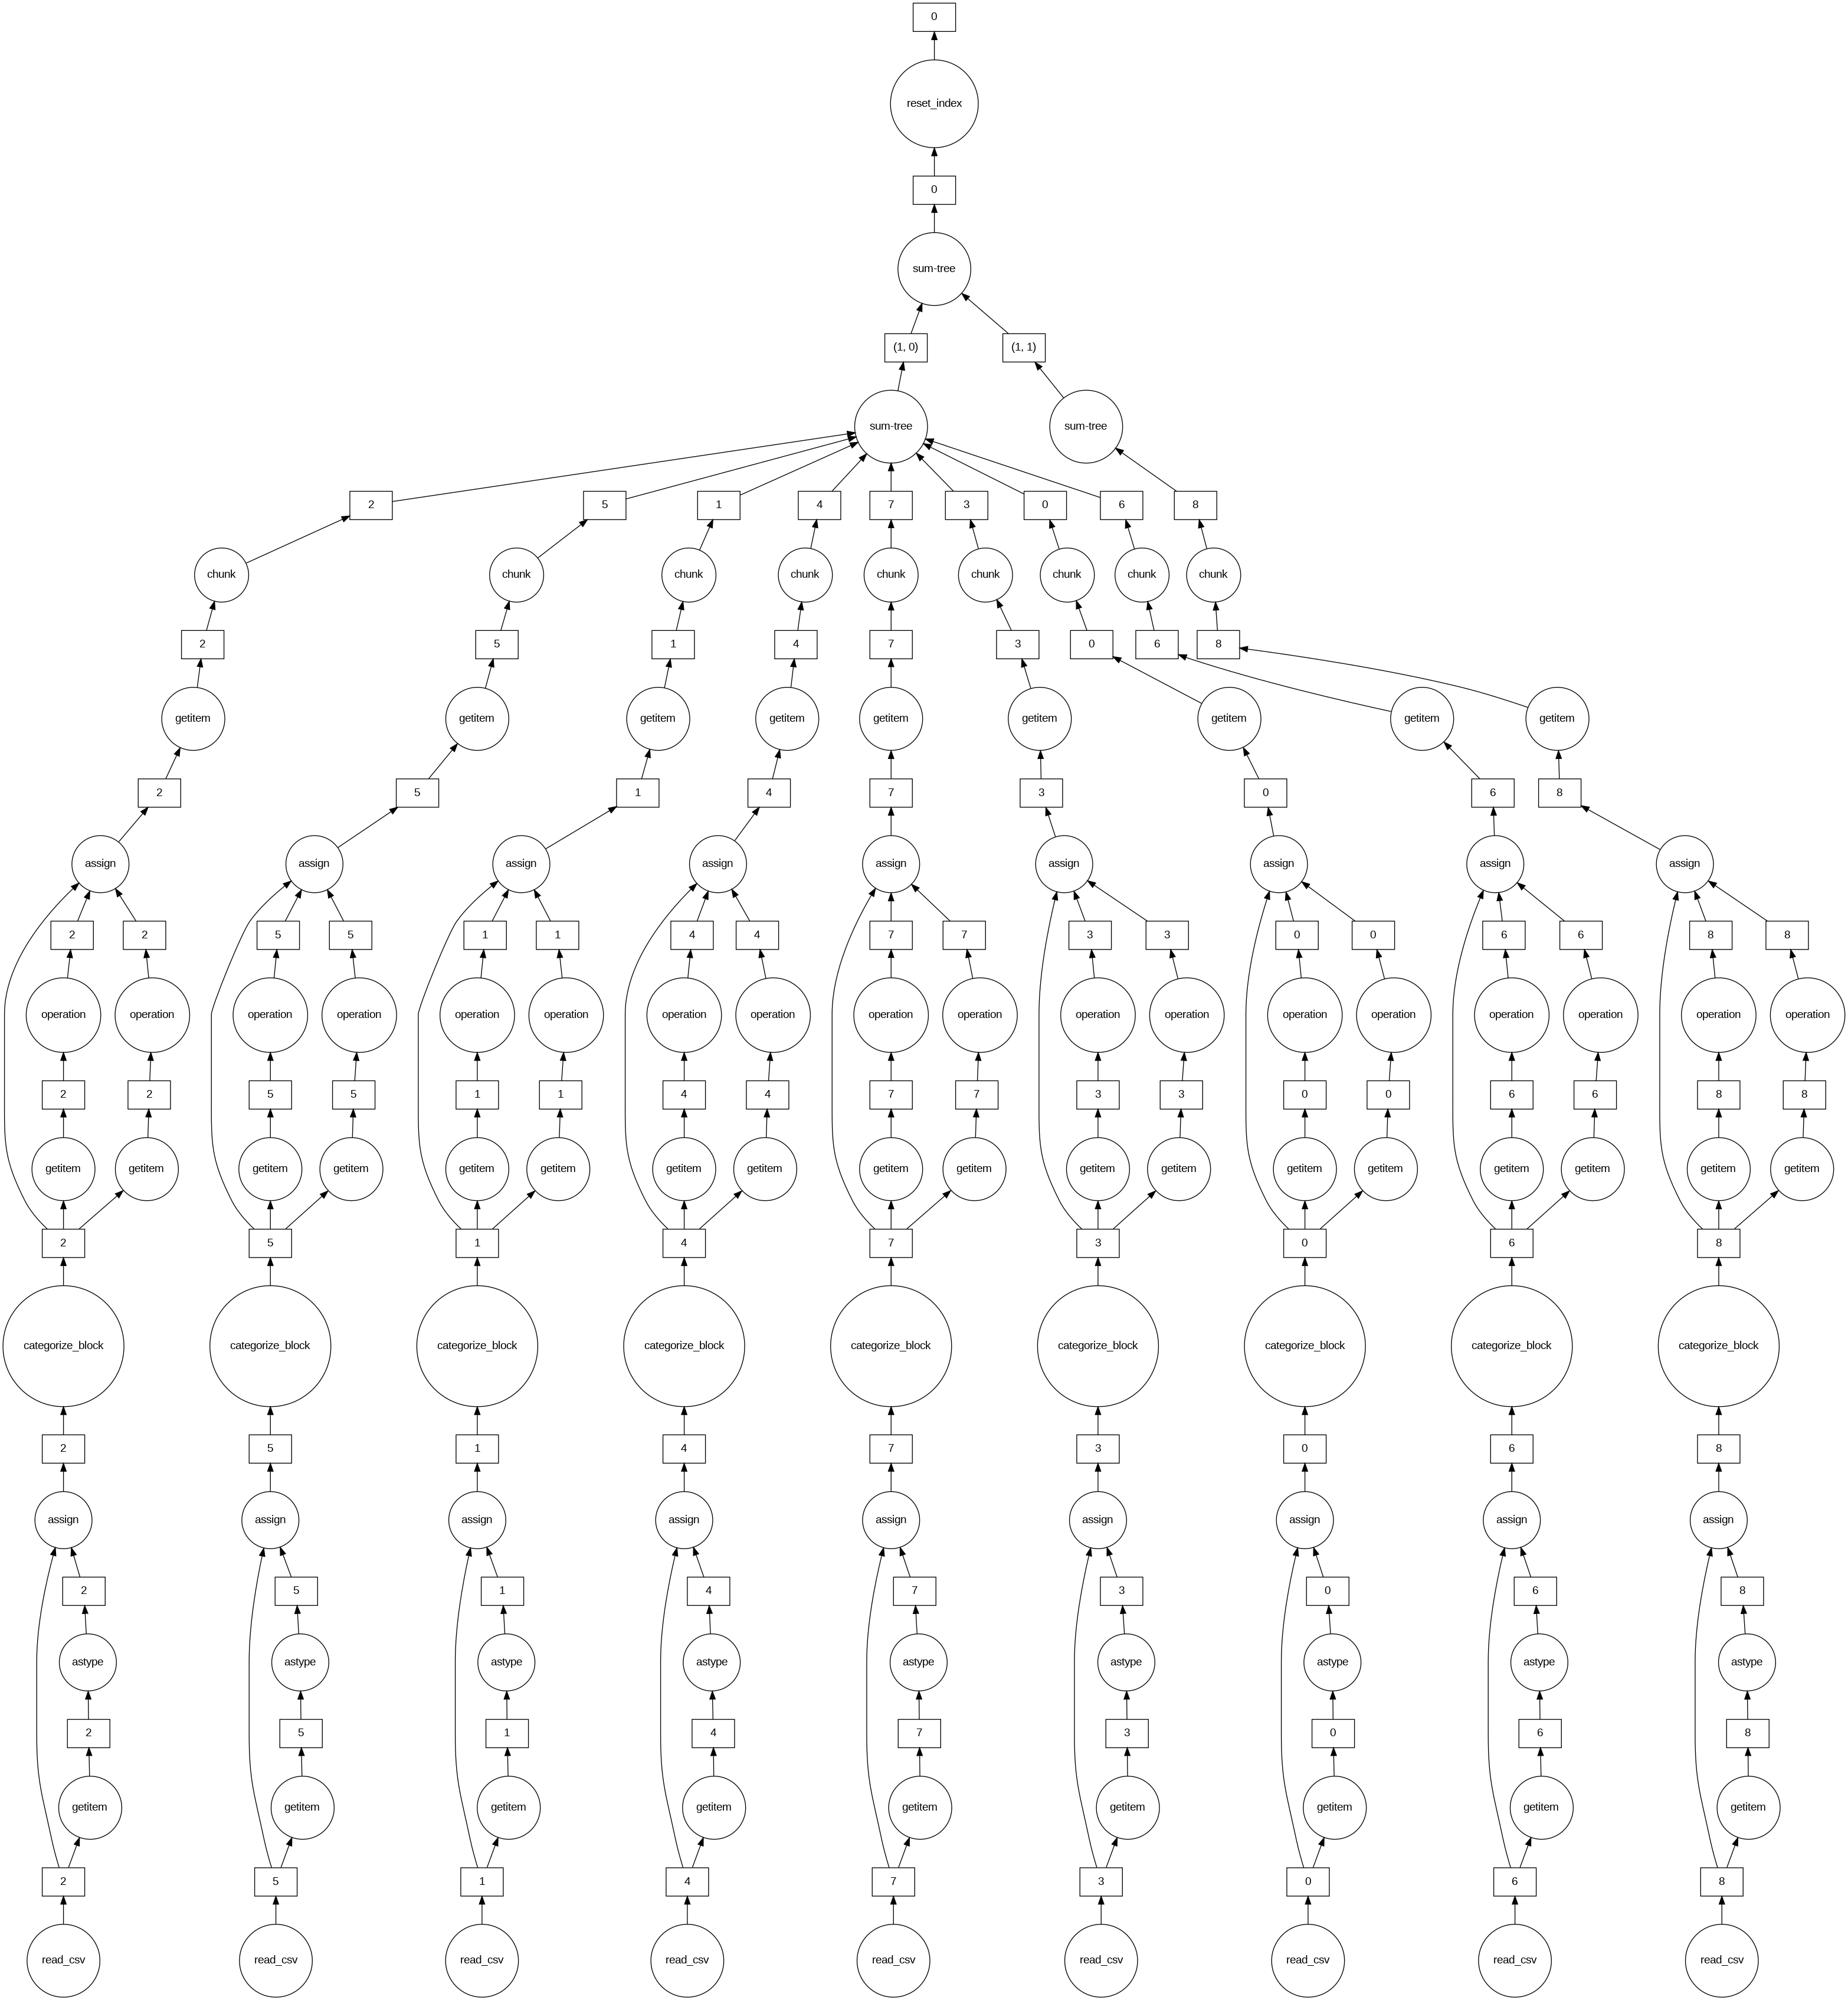

In [109]:
# Step 4: Compute the interaction matrix
# Dask doesn't support pivot tables directly, so we aggregate manually
interaction_array = df.groupby(['track_idx', 'user_idx'])['playcount'].sum().reset_index()

interaction_array.visualize(tasks=True)

- Groups data by track_id and user_id.
- Computes the sum of playcount for each (track_id, user_id) pair.
- Uses Dask's lazy computation, meaning no actual computation happens yet.

In [93]:
interaction_array = interaction_array.compute()

In [111]:
interaction_array

,track_idx,user_idx,playcount
npartitions=1,,,
,int16,int32,float64
,...,...,...


In [112]:
interaction_array

,track_idx,user_idx,playcount
npartitions=1,,,
,int16,int32,float64
,...,...,...


In [117]:
# step 5: Create a sparse matrix
# collect the data into a Numpy-friendly format

row_indices = interaction_array['track_idx']
col_indices = interaction_array['user_idx']
values = interaction_array['playcount']


In [118]:
row_indices.nunique()

<dask_expr.expr.Scalar: expr=(DropDuplicates(frame=(ResetIndex(frame=Sum(frame=(Assign(frame=Categorize(frame=Assign(frame=ReadCSV(50aee3f)), categories={'user_id': 271012    00000b722001882066dff9d2da8a775658053ea0
282179    00001638d6189236866af9bbf309ae6c2347ffdc
413851    0000175652312d12576d9e6b84f600caa24c4715
752325    00001cf0dce3fb22b0df0f3a1d9cd21e38385372
202926    0000267bde1b3a70ea75cf2b2d216cb828e3202b
                            ...                   
819195    ffffdc6c89988cd6119067769162948eacf8b670
844593    ffffe07df4bb5fd929efe42c5728f3a0c1621277
743202    fffff3e690fcda840b716ce7249d8935ff3323fc
571737    fffff67d54a40927c93d03bd6c816b034b59f087
884370    fffff9534445f481b6ab91c345500083d2ce4df1
Name: user_id, Length: 962037, dtype: object, 'track_id': 25631      TRAAAED128E0783FAB
1017033    TRAAAHD128F42635A5
704344     TRAAAQO12903CD8E1C
928        TRAABJS128F9325C99
472011     TRAABXA128F9326351
                  ...        
37141      TRZZYMU128E0792400
432929

In [119]:
# Build a sparse matrix
n_tracks = unique_tracks # (total unique tracks)
n_users = unique_users   # (total unique users)

sparse_matrix = csr_matrix((values, (row_indices, col_indices)), shape=(n_tracks, n_users))

# shape=(n_tracks, n_users) → Defines the matrix size

print('sparse matrix shape:', sparse_matrix.shape)
print('Non-zero elements:', sparse_matrix.nnz)

sparse matrix shape: (30459, 962037)
Non-zero elements: 430


**Why Use a Sparse Matrix?**

 - **Memory Efficiency**: Instead of storing a full 2D matrix (which can be huge), it stores only non-zero values.

 - **Fast Computation**: Matrix operations (dot products, SVD, etc.) are faster when using sparse representation.

 - **Scalability:** Useful for handling millions of users and tracks efficiently.

🔹 **Example Input & Sparse Matrix Construction**

Assume we have this interaction data:

| track_id | user_id | playcount |
|----------|---------|----------|
| 0        | 0       | 5        |
| 0        | 1       | 3        |
| 1        | 0       | 2        |
| 2        | 1       | 7        |


1. Extract Matrix Components

 - values = [5, 3, 2, 7]  # playcounts

 - row_indices = [0, 0, 1, 2]  # track_id

 - col_indices = [0, 1, 0, 1]  # user_id

2. Build the Sparse Matrix

 - from scipy.sparse import csr_matrix

 - n_tracks = 3  # Total unique tracks (rows)
 - n_users = 2   # Total unique users (columns)

 - sparse_matrix = csr_matrix((values, (row_indices, col_indices)), shape=(n_tracks, n_users))

 - print("Sparse matrix shape:", sparse_matrix.shape)  # Output: (3, 2)
 - print("Non-zero elements:", sparse_matrix.nnz)  # Output: 4

🔹 **Checking the Sparse Matrix**

You can view the non-zero elements in a dense format using:

- print(sparse_matrix.toarray())

🔹 Output:


  [[5 3]

  [2 0]

  [0 7]]

 - Row (tracks) → track_id
 - Column (users) → user_id
 - Values → playcount

**🔹 Key Takeaways**

1. ✅ Efficient storage → Saves memory by storing only non-zero elements.
2. ✅ Faster computations → Used in matrix factorization (SVD, ALS) for recommendations.
3. ✅ Scales to large datasets → Millions of users & tracks without consuming huge memory.

Would you like help applying this to a recommendation model? 🚀

In [120]:
sparse_matrix

<30459x962037 sparse matrix of type '<class 'numpy.float64'>'
	with 430 stored elements in Compressed Sparse Row format>

In [121]:
sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1])*100

1.4674423188505258e-06

In [122]:
sparse_matrix[0]

<1x962037 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [123]:
from sklearn.metrics.pairwise import cosine_similarity

In [124]:
np.where(df['track_id'].cat.categories == "TROINZB128F932F740")

""".cat.categories is an attribute used in Pandas Categorical Data
to access the unique category labels of a categorical column.
It returns an array-like list of unique categories."""

(array([17018]),)

In [125]:
ind = 17018

In [126]:
input_array = sparse_matrix[ind]

input_array

<1x962037 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [127]:
similarity_scores = cosine_similarity(input_array, sparse_matrix)

In [130]:
# To find top 6 largest values
np.sort(similarity_scores)[-6:][::-1]


# np.sort(similarity_scores): This sorts the similarity_scores array in ascending order
# [-6:]:  This slices the sorted array, keeping the last 6 elements.
# [::-1]: This part reverses the array, changing the order of the elements from ascending to descending.

array([[0., 0., 0., ..., 0., 0., 0.]])

In [131]:
similarity_scores.shape

(1, 30459)

In [133]:
# To find the indices of the top 6 highest values from the similarity_scores
np.argsort(similarity_scores.ravel())[-6:][::-1]

# similarity_scores.ravel():The ravel() function returns a flattened version(1D) of the array, regardless of its shape (2D, 3D, etc.).

array([30458, 10157, 10145, 10146, 10147, 10148])

In [134]:
np.argsort(similarity_scores.ravel())[-6:][::-1]

array([30458, 10157, 10145, 10146, 10147, 10148])

In [135]:
recommendations = df['track_id'].cat.categories[np.argsort(similarity_scores.ravel())[-6:][::-1]]

In [136]:
recommendations

Index(['TRZZZRJ128F42819AF', 'TRILRGB128F93369B6', 'TRILOSY128F1487256',
       'TRILOWN128F426080F', 'TRILPGN128E0783D69', 'TRILPHY128F42858B6'],
      dtype='object', name='track_id')

In [137]:
filtered_songs[filtered_songs["name"] == "Crazy in Love"]

,track_id,name,artist,spotify_preview_url
3337,TROINZB128F932F740,Crazy in Love,Beyoncé,https://p.scdn.co/mp3-preview/807828ea7070bda7...


In [139]:
def collaborative_recommendation(song_name,user_data,songs_data,interaction_matrix,k=5):
    # fetch the row from songs data
    song_row = songs_data[songs_data["name"] == song_name]
    print(song_row)
    # track_id of input song
    input_track_id = song_row['track_id'].values.item()
    print(input_track_id)
    # index value of track_id
    ind = np.where(user_data['track_id'].cat.categories == input_track_id)[0].item()
    print(ind)
    # fetch the input vector
    input_array = interaction_matrix[ind]
    # get similarity scores
    similarity_scores = cosine_similarity(input_array, interaction_matrix)
    # get top k recommendations
    recommendation_track_ids = df['track_id'].cat.categories[np.argsort(similarity_scores.ravel())[-k-1:][::-1]]
    print(recommendation_track_ids)
    # get top scores
    top_scores = np.sort(similarity_scores.ravel())[-k-1:][::-1]
    print(top_scores)
    # get the songs from data and print
    temp_df = pd.DataFrame({"track_id":recommendation_track_ids.tolist(),
                            "score":top_scores})
    print(temp_df)
    top_k_songs = (
                    songs_data
                    .loc[songs_data["track_id"].isin(recommendation_track_ids)]
                    .merge(temp_df,on="track_id")
                    .sort_values(by="score",ascending=False)
                    .drop(columns=["track_id","score"])
                    .reset_index(drop=True)
                    )
    return top_k_songs

In [140]:
collaborative_recommendation(song_name="Crazy in Love",
                             user_data=df,
                             songs_data=filtered_songs,
                             interaction_matrix=sparse_matrix)

                track_id           name   artist  \
3337  TROINZB128F932F740  Crazy in Love  Beyoncé   

                                    spotify_preview_url  
3337  https://p.scdn.co/mp3-preview/807828ea7070bda7...  
TROINZB128F932F740
17018
Index(['TRZZZRJ128F42819AF', 'TRILRGB128F93369B6', 'TRILOSY128F1487256',
       'TRILOWN128F426080F', 'TRILPGN128E0783D69', 'TRILPHY128F42858B6'],
      dtype='object', name='track_id')
[0. 0. 0. 0. 0. 0.]
             track_id  score
0  TRZZZRJ128F42819AF    0.0
1  TRILRGB128F93369B6    0.0
2  TRILOSY128F1487256    0.0
3  TRILOWN128F426080F    0.0
4  TRILPGN128E0783D69    0.0
5  TRILPHY128F42858B6    0.0


,name,artist,spotify_preview_url
0,Underneath Your Clothes,Shakira,https://p.scdn.co/mp3-preview/6c5a56058ce04371...
1,They Live In the Meadow,Black Moth Super Rainbow,https://p.scdn.co/mp3-preview/93ef30347ae52c98...
2,Bigger,Justin Bieber,https://p.scdn.co/mp3-preview/96f5d8f620467dfa...
3,Lord Anthony,Belle and Sebastian,https://p.scdn.co/mp3-preview/c7835d4b82ca1392...
4,Amy in the White Coat,Bright Eyes,https://p.scdn.co/mp3-preview/16b02c2bc70d5bc7...
5,Pensando En Ti,Mägo de Oz,https://p.scdn.co/mp3-preview/4e8b1b9e27ffdc9a...
